# Import necessities


In [70]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build the model

In [55]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Define the parameters here
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.c1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) # Input(3, 32, 32) Output(6, 28, 28)
        self.s2 = nn.MaxPool2d(2, 2) # Output (6, 14, 14)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # Input(6, 14, 14) Output(16, 10, 10)
        self.s4 = nn.MaxPool2d(2, 2) # Output (16, 5, 5)
        self.c5 = nn.Linear(16 * 5 * 5, 120)
        self.f6 = nn.Linear(120, 84)
        self.out = nn.Linear(84, 10)

    def forward(self, x):
        x = self.relu(self.c1(x))
        x = self.s2(x)
        x = self.relu(self.c3(x))
        x = self.s4(x)
        x = self.relu(self.c5(x.view(x.size()[0], -1)))
        x = self.relu(self.f6(x))
        x = self.out(x)

        return x

model = LeNet().to(device)
# 使用随机生成的样例测试模型
# 四个维度分别为[batch_size, channels, height, width]
t1 = torch.rand([10, 3, 32, 32])
model(t1)

tensor([[ 0.0293, -0.0268, -0.0338,  0.0453,  0.0303, -0.1096,  0.0133,  0.1032,
          0.0583, -0.0488],
        [ 0.0290, -0.0317, -0.0345,  0.0428,  0.0265, -0.1141,  0.0125,  0.1028,
          0.0603, -0.0515],
        [ 0.0334, -0.0284, -0.0285,  0.0432,  0.0348, -0.1130,  0.0180,  0.1011,
          0.0559, -0.0557],
        [ 0.0263, -0.0359, -0.0311,  0.0429,  0.0291, -0.1158,  0.0167,  0.1029,
          0.0577, -0.0532],
        [ 0.0295, -0.0225, -0.0256,  0.0399,  0.0336, -0.1104,  0.0105,  0.1032,
          0.0593, -0.0477],
        [ 0.0357, -0.0307, -0.0291,  0.0430,  0.0363, -0.1171,  0.0169,  0.1042,
          0.0629, -0.0449],
        [ 0.0362, -0.0321, -0.0310,  0.0462,  0.0331, -0.1106,  0.0139,  0.1058,
          0.0572, -0.0486],
        [ 0.0285, -0.0257, -0.0253,  0.0412,  0.0328, -0.1145,  0.0122,  0.0994,
          0.0580, -0.0548],
        [ 0.0256, -0.0296, -0.0261,  0.0417,  0.0324, -0.1151,  0.0139,  0.1033,
          0.0585, -0.0511],
        [ 0.0280, -

# Set optimizer and loss function

In [91]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

torch.Size([10, 10])


# Load data for training
和MNIST类似，加载数据集有两种方式torch.utils.data.DataLoader
- 使用Dataset与DataLoader加载
- 使用官方提供的函数加载

其中前者由于torchvision中提供了函数`torchvision.datasets.CIFAR10`，不用手写继承 Dataset 类处理函数，因此更为方便

In [260]:
# 使用torchvision提供的函数
import torchvision.transforms as transforms
# 归一化，after = (before - mean) / std
# 前三个0.5代表每个通道的mean 后三个代表每个通道的std
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./src/', train=True,
                                         download=False, transform=transform)
train_loader = Data.DataLoader(train_set, batch_size=36,
                                           shuffle=False, num_workers=0)

test_set = torchvision.datasets.CIFAR10(root='./src/', train=False,
                                         download=False, transform=transform)
test_loader = Data.DataLoader(test_set, batch_size=5000,
                                         shuffle=False, num_workers=0)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        _dict = pickle.load(fo, encoding='bytes')
    return _dict
a = unpickle("./src/cifar-10-batches-py/data_batch_1")

以下函数可显示读取到的数据，可用于检测数据是否正确读取

此外需要注意的是，DataLoader类型的数据需要转化为迭代器后取出

`np.transpose`用于调整图片的维度顺序，原本为[3, 32, 32]，调整后为[32, 32, 3]以便输出

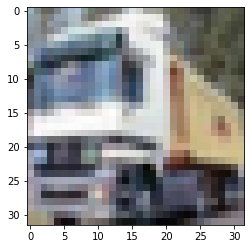

(32, 32, 3)

In [301]:
# 展示图片
def img_show(data):
    data = data / 2 + 0.5
    plt.imshow(np.transpose(data.numpy(), (1, 2, 0)))
    plt.show()

img_data = iter(train_loader)
img_data, _ = next(img_data)
img_show(img_data[1])
data = img_data[1] / 2 + 0.5
np.transpose(data.numpy(), (1, 2, 0)).shape

# Start Training

In [274]:
model.train()
epochs = 5
for epoch in range(epochs):
    sum_loss = .0
    for i, (in_data, out_data) in enumerate(train_loader):

        in_data = in_data.to(device)
        out_data = out_data.to(device)
        pred = model(in_data)
        loss = criterion(pred, out_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss
    print("epoch ", epoch, "  Loss: ", np.float32(sum_loss.data))

epoch  0   Loss:  915.5132
epoch  1   Loss:  914.79663
epoch  2   Loss:  903.1804
epoch  3   Loss:  899.42773
epoch  4   Loss:  895.97266


# Test

In [273]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (in_data, out_data) in enumerate(test_loader):
        outputs = model(in_data)
        _, predicted = torch.max(outputs.data, 1)
        total += out_data.shape[0]
        correct += (predicted == out_data).sum()
print("Correct rate: ", np.float32(100 * correct / total), "%")


Correct rate:  54.98 %
